In [4]:
# Initialize Otter
import otter
grader = otter.Notebook("lab04.ipynb")

# Lab 4:  Bayesian Estimation in Hierarchical Graphical Models
Welcome to the fourth Data 102 lab! 

The goal of this lab is to go over Bayesian Estimation and provide an introduction to Hierarchial Graphical Models.

The code and responses you need to fill in are represented by `...`. There is additional documentation for each part as you go along. 


## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
See the [Gradescope Submission Guidelines post](https://edstem.org/us/courses/52891/discussion/4179226) for details on how to submit your lab.

**For full credit, this assignment should be completed and submitted before Wednesday, Feburary 14th, 2023 at 11:59 PM PST.**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, binom
import itertools
from ipywidgets import interact, interactive


import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

import pymc as pm
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.INFO)

# Question 1: Beta-Binomial Graphical Model

In this question we will look at the COVID modeling example. Here's the summary of what you need to know:

In this problem we are trying to estimate the COVID infection risk in households. To do that we curate a list of K studies. Each study has an associated pair $(N_i, X_i)$ where $N_i$ denotes the number of susceptible individuals considered and $X_i$ is the number of them that became infected. In our modeling assumptions we assume that each susceptible person gets infected with probability $\theta_i$. In epidemiology, this quantity is known as Secondary Attack Rate, or SAR for short.

We're trying to do two things: 
1. We want to *combine* the information from all the studies, so we can get a better estimate of SAR than we would with any individual study on its own. 
2. We want to understand why the studies got different results: specifically, we'd like to figure out the regions with the *lowest* SAR, so that we can investigate what contributed to their relative success. In the other direction, we want to know which regions had the *highest* SAR, since they're likely the ones most urgently in need of intervention measures to help slow the spread.


In [6]:
# Read out a dataset 
study_df = pd.read_csv("study_df.csv", header=0)
study_df

,Name,X,N
0,Study 0,3,8
1,Study 1,2,11
2,Study 2,6,12
3,Study 3,9,27
4,Study 4,11,38
5,Study 5,21,59
6,Study 6,27,79
7,Study 7,23,82
8,Study 8,26,120
9,Study 9,57,145


## 1a) Compute the naive estimate of SAR


The most straightforward way to estimate the probability of infection (SAR) is to divide the number of infected cases by the number of susceptible cases. 

Compute this quantity in the cell below.

In [7]:
# TODO: Complete the function
def trivial_theta_estimate(N_value, X_value):
    """
    Computes the trivial estimate of the Secondary Attack Rate
    
    Inputs:
        N_value : int, number of susceptible individuals
        X_value : int, number of infected individuals
        
    Output:
        theta_est : float, estimate of probability of infection (SAR)
    """
    theta_est = X_value/N_value
    return theta_est

In [8]:
grader.check("q1a")

q1a results: All test cases passed!

In [9]:
# Apply  'trivial_theta_estimate' to each row of the dataframe and add a new column to hold the result
study_df['Trivial estimate'] = study_df.apply(lambda row: trivial_theta_estimate(row['N'], row['X']), axis =1)
study_df.sort_values('Trivial estimate')

,Name,X,N,Trivial estimate
1,Study 1,2,11,0.181818
8,Study 8,26,120,0.216667
7,Study 7,23,82,0.280488
4,Study 4,11,38,0.289474
3,Study 3,9,27,0.333333
6,Study 6,27,79,0.341772
5,Study 5,21,59,0.355932
11,Study 11,122,341,0.357771
0,Study 0,3,8,0.375000
9,Study 9,57,145,0.393103


**Trivial estimates suggest that both minimum and maximum probabilities of infection correspond to small studies.**

|      | Min     | Max     |
|------|---------|---------|
| Name | Study 1 | Study 2 |
| X    | 2       | 8       | 
| N    | 11      | 12      |
|$\theta$| 0.18  | 0.50    |


Intuitively, we probably shouldn't be making policy decision based on such small studies alone, especially when this dataset has other studies with tens or even hundreds of people. We would like to balance between strong evidence from the small studies and high confidence in estimates from larger studies.

Bayesian inference provides a flexible framework to balance our a priori beliefs with new evidence. Consider the following graphical model:


![](model.png)


The circles represent random variables, and shaded circles represent observed random variables. The diamond at the top represents fixed, unknown parameters . You'll also see people draw dots or squares for these: there isn't really one consistent notation.

Here are a few important quantities in Bayesian inference. This lingo will be used at length in this course and in anything you'll learn in the future about Bayesian inference, so make sure you get familiar with it.  

### Joint Density / Joint Distribution:
The structure of the graphical model specified the full joint density of the parameters and data in the model. For this example the joint density is:
$$p(\theta_1, \theta_2, \ldots, \theta_K, X_1, \ldots, X_K) = \prod_{\text{vertex $V$ in graph}}p(V|\text{parent of $V$}) = \prod_{i=1}^K \underbrace{p(\theta_i|\alpha, \beta)}_{\text{prior of $\theta_i$}} \prod_{i=1}^K \underbrace{p(X_i|\theta_i)}_{\text{likelihood of data $X_i$}}$$

The factorization of the joint density into products of priors and likelihoods is the key feature of Hierarchical Models. It allows to take a complex $2K$-dimensional joint probability and factorize it into products of 1-dimensional probabilities. This factorization is useful because it lets us simplify the distribution and control the amount of computation we have to do.


### Prior:  $\theta_i \sim {\rm Beta}(\alpha, \beta)$

We have the prior distribution:

\begin{align}
p(\theta_i) 
    &= \theta_i^{\alpha-1}(1-\theta_i)^{\beta-1} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \\
    &\propto_{\theta_i}\theta_i^{\alpha-1}(1-\theta_i)^{\beta-1}
\end{align}

where $\Gamma$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function). Since $\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}$ does not depend on the value of $\theta$. It is a scaling factor that ensures that $p(\theta_i)$ is a valid probability function. This leads to a common notation in practice: $p(\theta_i)\propto_{\theta_i}\theta_i^{\alpha-1}(1-\theta_i)^{\beta-1}$. The symbol $\propto_{\theta_i}$ means proportional in $\theta_i$. This is a little more explicit than the $\propto$ notation that you usually see.

### Likelihood: $X_i|\theta \sim {\rm Binomial}(N_i, \theta_i)$

We'll use the notation $p(X_i|\theta)$ for the likelihood function, which represents our belief about the distribution of the data if we know what the parameter $\theta$ is (in other words, if we condition on $\theta$).
$$p(X_i|\theta_i) = \binom{N_i}{X_i} \theta_i^{X_i}(1-\theta_i)^{N_i - X_i}$$

### Marginal: Unconditional distribution of $X_i$:

\begin{align}
p(X_i)
    &= \int_{\theta_i} \overbrace{p(X_i, \theta_i)}^{\text{joint distribution}} \\
    &= \int_0^1 \underbrace{p(X_i|\theta_i)}_{\text{likelihood}} \,\underbrace{p(\theta_i)}_{\text{prior}} \,d\theta_i
\end{align}

This is the marginal distribution over the data: we can plug in a particular set of $X_i$ values and get out the probability that our model assigns to those values, averaged over all possible values of $\theta$.

When formulating a model, we usually choose the prior and the likelihood based on what we know about the problem. This means that computing this marginal distribution over $X_i$ requires *marginalizing* over the parameter $\theta$: that involves either a summation or an integral (in this case it's an integral because $\theta$ is continuous).

### Posterior: $\theta_i|X_i$
The goal of many estimation problems is to obtain the posterior distribution of the parameter of interest $\theta_i$ conditioned on the data $X_i$.

\begin{align}
p(\theta_i|X_i) &= \frac{p(X_i|\theta_i)p(\theta_i)}{p(X_i)} \quad \text{(by Bayes Rule)}\\
&\propto_{\theta} p(X_i|\theta_i)p(\theta_i) \quad \text{(the data marginal $p(X_i)$ does not depend on $\theta$)}\\
&\propto_{\theta}  \underbrace{\theta_i^{X_i}(1-\theta_i)^{N_i - X_i}}_{\text{likelihood}} \underbrace{\theta^{\alpha-1}(1-\theta)^{\beta-1}}_{\text{prior}}\\
&\propto_{\theta}\theta_i^{\alpha + X_i - 1}(1-\theta_i)^{\beta + N_i - X_i - 1} \quad \text{unnormalized Beta density}\\
\end{align}

### Hence $\theta_i|X_i \sim {\rm Beta}(\alpha + X_i, \beta + N_i - X_i)$

The fact that the posterior probability comes from the same distribution family as the prior is known as *conjugacy*. It is a very useful property because it allows us to compute the posteriors in closed form.

<!-- BEGIN QUESTION -->

## 1b) Conceptual
When specifying a Bayesian model, we use our domain knowledge to establish certain distributions, and then we use computation to find other ones. Which of the following do we establish using our domain knowledge? Pick all that apply.

(a) Prior

(b) Likelihood

(c) Marginal distribution of the data

(d) Posterior 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## 1c) Examine the prior distribution

Before we jump into our COVID meta-analysis, let's start by gaining some intuition about our prior, the Beta distribution.

In [10]:
def plot_beta(alpha_value, beta_value):
    x = np.arange(0, 1.01, 0.01)
    y = beta.pdf(x, alpha_value, beta_value)
    fig = plt.figure()
    plt.plot(x, y)
    plt.xlabel(r'$\theta_i$')
    plt.ylabel(r'$p(\theta_i)$')
    plt.title(r'Beta distribution with parameters $\alpha$ and $\beta$')
    plt.ylim(0, 10)
    plt.show() 

In [11]:
interactive_plot = interactive(plot_beta, alpha_value=(1, 20, 0.5), beta_value=(1,20, 0.5))
interactive_plot

interactive(children=(FloatSlider(value=10.0, description='alpha_value', max=20.0, min=1.0, step=0.5), FloatSl…

<!-- BEGIN QUESTION -->

### 1c (i)
Fix `alpha_value = 5`, and experiment with different values of `beta_value`. As we increase `beta_value`, what happens to the mode of the distribution?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 1c (ii) 
Fix `beta_value = 5`, and experiment with different values of `alpha_value`. As we increase `alpha_value`, what happens to the mode of the distribution?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 1c (iii) 
Set `alpha_value = beta_value = 1`, increase their value such that `alpha_value=beta_value`. What happens to the *variance* of the distribution? 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## 1d) Compute Posterior Mean Estimates for SAR
As we saw in [Discussion 3 Question 3](https://drive.google.com/file/d/1g0EJRD5a6RlJ2D_qVKcA3BRObzOzvBc6/view), the **posterior mean** minimizes the **Bayes Risk** for the **Squared Error Loss**. In light of this fact, we'll use the mean of the posterior distribution to estimate the Secondary Attack Rate (SAR).

**In the cell below, write a function that computes the posterior mean corresponding to $\theta_i|X_i$.**

*Hint: If you need to look up facts about certain well-known distributions, you can always (a) go to textbooks from classes you've taken before, (b) look on Wikipedia, or (c) do a simple web search.*

In [12]:
# TODO: complete the function
def posterior_mean_estimate(N_value, X_value, alpha_value, beta_value):
    """
    Computes the posterior E[theta_i|X_i] when we consider a prior theta_i ~ Beta(alpha, beta)
    
    Inputs: 
        N_value : int, total number of susceptible individuals
        X_value : int, number of individuals that became infected
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
    """
    posterior_mean = (alpha_value + X_value)/(alpha_value + beta_value + N_value)
    return posterior_mean

In [13]:
grader.check("q1d")

q1d results: All test cases passed!

## 1e) Examine the posterior mean estimate

Let's assume that from domain knowledge, we think that the probability of infection (SAR) is close to $\frac{1}{3}$. We pick a prior distribution for $\theta_i$ that has mean $\frac{1}{3}$. Any distribution of the form $\theta_i \sim {\rm Beta}(k, 2k)$ has this property. The value of $k$ determines the 'strength' of the prior. Low values of $k$  correspond to 'flatter' priors, while larger values of $k$ correspond to 'peakier' priors. Play with the sliders in `q1c` to convince yourself.

**Examine the plotting function below and answer the qualitative questions in the next cells.**

In [14]:
# Do not modify: Examine the code
def plot_thetas(k):
    
    study_df["bayesian_theta"] = study_df.apply(
        lambda row: posterior_mean_estimate(row['N'], row['X'], k, 2*k), 
        axis=1
    )
    study_df["trivial_theta"] = study_df.apply(
        lambda row: trivial_theta_estimate(row['N'], row['X']), 
        axis=1
    )
    fig = plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    graph = sns.scatterplot(
        x="trivial_theta", y="bayesian_theta", 
        data=study_df, size="N", sizes=(50, 300), alpha=.8
    )
    sns.lineplot(
        x='trivial_theta', y='trivial_theta', 
        data= study_df, ls="--", color='black', lw=1
    )
    plt.ylim(0.16, 0.52)
    graph.axhline(
        1/3, color='black', 
        label = "$\frac{1}{3}$ Prior Expectation"
    )
    plt.xlabel('Trivial Estimate')
    plt.ylabel('Posterior Mean Estimate')
    
    plt.subplot(1, 2, 2)
    x = np.arange(0,1.01,0.01)
    y = beta.pdf(x, k, 2*k)
    plt.plot(x, y)
    plt.xlabel(r'$\theta_i$')
    plt.ylabel(r'$p(\theta_i)$')
    plt.title(rf'Prior: $Beta(\alpha={k}, \beta={2*k})$')
    plt.ylim(0, 10)
    plt.show()

In [15]:
interactive_plot = interactive(plot_thetas, k=(0, 50, 2))
interactive_plot

interactive(children=(IntSlider(value=24, description='k', max=50, step=2), Output()), _dom_classes=('widget-i…

In the plot above the solid horizontal line represents the prior mean estimate $\mathbb{E}[\theta_i] = \frac{k}{k+2k} = 1/3$. The dashed diagonal line marks $x=y$. Each data-point corresponds to a study, the size of the marker denotes the number of susceptible individuals in each study. Such that larger markers correspond to larger studies.

**Based on your observations of the interactive plot above, answer the following questions.**

<!-- BEGIN QUESTION -->

### 1e (i) 
Start by setting $k=0$, and then steadily increase the value of $k$. Record your observations using **2-3 sentences** in the space below. Be sure to address the following questions:
1. At $k=0$, where do the data points lie relative to the horizontal and diagonal lines? Why?
2. As we increase the value of $k$, do the points move towards or away from the horizontal line? Why?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 1e (ii) 

As you increase $k$, some points move faster than others. Which points move faster, the larger or smaller data points? Explain why this is the case in **1-2 sentences**.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 1e (iii) 
Imagine that we let $k\to \infty$. How do you think the two graphs above will look in the limit $k\to \infty$? Limit your response to **1-2 sentences**.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 1e (iv) 

Fill in the blank in this sentence with either "small" or "large", and explain your answer in **1-2 sentences**: 

*If we're very sure that the true SAR is close to $\frac{1}{3}$, we should choose a _______ value of $k$.*

_Type your answer here, replacing this text._

<!-- END QUESTION -->

# Question 2: Computational Approximate Inference

In the previous question we looked at a Beta-Binomial Graphical model. We took advantage of the conjugacy properties of the model and were able to compute closed form solutions for the posterior mean estimates.

However, as we introduce more complexity to the model, the **conjugacy property quickly breaks and we have to resort to approximate inference**. In this class, we'll focus primarily on *sampling* for approximate inference: this will be the topic of the next few lectures and next week's labs. In sampling-based approaches, **we don't even try to get the exact posterior: instead, we generate a bunch of samples from it, and use those to approximate the distribution.**

In this question you will get a taste for probabilistic programming using `PyMC`. Spend some time perusing the [documentation](https://docs.pymc.io/), but don't worry if there are parts that don't make sense yet. The Quickstart guide is a useful starting point. 

We'll be using PyMC to run an algorithm called Markov Chain Monte Carlo (MCMC), which you'll learn about this week and next. We'll start by using the same model from `Question 1`, and compare the results from MCMC with the exact solutions we calculated above. Then, we'll add an extra parameter to the model and make things more complex: even though we can no longer compute our posterior in closed form, MCMC will still generate samples that we can use to estimate each $\theta_i$.

In [16]:
# Create a dummy model so that one-time initialization
# happens while you're reading over the code in the next cell.

# Note: this and the following cells may take a while to run

# You can ignore the output of this cell.

with pm.Model() as model:
    dummy = pm.Beta('dummy', alpha=1, beta=1)
    pm.sample(1, return_inferencedata=False, progressbar=False)

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 1 draw iterations (4_000 + 4 draws total) took 1 seconds.
/srv/conda/envs/notebook/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The number of samples is too small to check convergence reliably.


## 2a) Building and sampling from a PyMC model

First, let's get acquainted with the structure of PyMC, and show that methods of approximate inference are (in many cases) just as good as having access to the exact distribution. Just like in `Question 1`, we're still trying to estimate the SAR using the posterior mean; only this time, we'll be using PyMC to get an approximate answer!

#### So, how does PyMC work? What does it even do?

In essence, PyMC is just a number generator with extra steps. Given a *likelihood* and a *prior*, it simulates thousands of samples to create an empirical distribution that approximates the true posterior distribution. With those samples, we're able to calculate values of interest (such as the posterior mean, MAP, etc.), and create estimates of $\theta$.

#### How do we tell PyMC what our model looks like?

As in any Bayesian parameter estimation problem, in order to find the posterior distribution, we must supply a **likelihood** and **prior**. To do this, we can instantiate [`Distribution`s](https://www.pymc.io/projects/docs/en/v3/Probability_Distributions.html) and their associated parameters to represent the random variables in our problem (you can take a look [here](https://www.pymc.io/projects/docs/en/v3/api/distributions.html) for a list of supported distributions).

Once defined, these distribution objects are like any random variable in statistics; you can add, subtract, multiply, divide, and use mathematic operators on them (though sometimes you may need to use PyMC's own math operators). They can also function as either likelihoods or priors, depending on the parameters you feed them:
1. If a `Distribution` object's parameters **do not** depend on other `Distribution` objects, these represent **priors**.
2. If a `Distribution` object's parameters **do** depend on other `Distribution` objects, these represent **likelihoods**.

#### What about our data?

Now that we've specified a likelihood and prior, we have to consider our *data*; remember, the posterior describes the distribution of $\theta$ given the data we observed! To do this, the `Distribution` class has a nifty little argument that we can pass in called `observed`. Using the `observed` argument, we can pass in our observed data to the random variable/`Distribution` object that corresponds to our observations, and let PyMC handle the rest!

#### Now, try it out for yourself!

Take a look at the cell below, and **define the theta and X nodes to approximate the posterior distribution.** The PyMC website has documentation for defining variables according to the Beta and Binomial distribution. If you have no idea how to proceed, the PyMC Quickstart guide is a great place to start!

In [23]:
# TODO: complete the function
def approximate_inference_MCMC(
    alpha_value, beta_value, study_df = study_df
):
    """
    Creates and generates samples from a PyMC model of
    the posterior distribution that corresponds to the
    graphical model in Q.1, using Markov Chain Monte Carlo (MCMC)
    
    Inputs:
        alpha_value, beta_value : floats, parameters of
        the prior Beta Distribution
        study_df : DataFrame containing study data
    
    Outputs: (model, trace)
        model is a PyMC model object, which represents the graphical model
        trace is a PyMC trace object, which represents 2000 samples
            of everything from the posterior
    """
    # Defines the graphical model
    with pm.Model() as model:
        # The prior for theta is a Beta distribution with parameters
        # alpha and beta, and there's one for each study.
        # Make sure to name this parameter 'theta' so so this lab can reference it later. 
        theta = pm.Beta('theta', alpha = alpha_value, beta = beta_value, shape = len(study_df))
        
        # The likelihood for X is binomial, with parameter p=theta,
        # observed counts in study_df['X'], and observed N similarly
        X = pm.Binomial('X', p = theta, observed = study_df['X'], n = study_df['N'])
        
        # Generate samples from the posterior distribution using : run 4
        # Markov chains of sampling in parallel, generating 500 samples
        # each.
        trace = pm.sample(500, chains=4, tune=1000, target_accept=0.95, return_inferencedata=False, progressbar=False)
    
    return (model, trace)

In [24]:
grader.check("q2a_i")

q2a_i results: All test cases passed!

Now, when we call the `approximate_inference_MCMC` function, we run the sampler and pass in fixed values of the hyperparameters alpha and beta.

In [25]:
# Run approximate inference
model, trace = approximate_inference_MCMC(10, 20)

# Get posterior samples of theta
thetas = trace['theta']
thetas
print(thetas.shape)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.


(2000, 12)


<!-- BEGIN QUESTION -->

Note that the shape of ``thetas`` is (N x M).  What are N and M, and what does each mean?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 2b) Using the output of PyMC

Now that we've run our sampler, we now have access to the posterior distributions of *all* the random variables we defined in PyMC. Using these empirical distributions, we can now calculate the posterior means for each $\theta_i$. But before we do that, let's visualize the samples we got back.

Generate a histogram of all 2,000 posterior samples for $\theta_2$ (the SAR for Study 2). Use the `sns.histplot` function with `stat='density'`.

<Axes: ylabel='Count'>

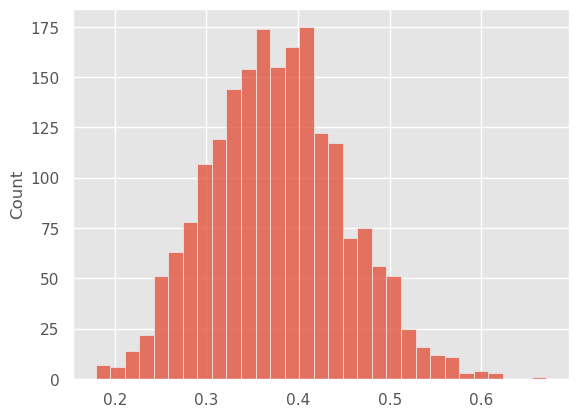

In [27]:
# TODO: Create histogram of posterior samples
sns.histplot(thetas[:, 2])

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

How do the samples compare to the two different estimates you saw in Question 1?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## 2c) Compute Posterior Mean Estimates from Samples

Fill in the function that computes posterior mean estimates for each $\theta_i$ for different parameters $\alpha, \beta$ of the prior distribution.

In [28]:
def empirical_posterior_mean_estimates(alpha_value, beta_value, study_df = study_df):
    """ 
    Computes posterior mean estimates of theta_i by performing approximate inference
    and then sampling from the posterior distribution:
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        
    Output:
        posterior_estimates : (num_studies,) 1-D array of the same length as the 
            number of studies. posterior_estimates[i] contains the 
            mean estimate for theta_i based on running MCMC
    
    """
    model, trace = approximate_inference_MCMC(alpha_value, beta_value, study_df)

    # Get posterior samples of theta
    thetas = trace['theta']
    posterior_estimates = np.mean(thetas, axis = 0)
    return posterior_estimates

In [29]:
grader.check("q2c")

q2c results: All test cases passed!

## 2d) Comparing Results from Question 1 and Question 2

Now that we've utilized conjugacy to get the theoretical distribution of the exact posterior (`Question 1`) and applied Markov Chain Monte Carlo to get an approximate empirical distribution (`Question 2`), let's compare the two to see how good our approximation was!

Below, we've provided code to make a 4x3 plot such that each subplot corresponds to a study. 

Each subplot contains 2 curves and a frequency histogram:
- The PDF of the prior distribution of $\theta_i$
- The PDF of the true posterior distribution $\theta_i|X_i$ computed in closed form, as in Q.1
- The histogram of posterior samples of $\theta_i|X_i$ computed in Q.2

Take a look through the subplots, and compare the fit between our empirical and theoretical distributions.

In [30]:
def plot_densities(alpha_value, beta_value, study_df = study_df): 
    """
    Plots for each study the prior distribution, true posterior,
    and histogram of posterior samples using MCMC
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        
    Outputs:
        fig : Figure with 12 subplots
    """
    fig, axs = plt.subplots(4, 3)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    
    theta = np.arange(0, 1.01, 0.01)
    prior = beta.pdf(theta, alpha_value, beta_value)
    
    model, trace = approximate_inference_MCMC(alpha_value, beta_value, study_df) 
    samples = trace['theta'] 
    
    for i in range(4):
        for j in range(3):
            idx = 3*i+ j
            X_i = study_df.loc[idx, 'X']
            N_i = study_df.loc[idx, 'N']
            study_name = f'Study {idx}'
            true_posterior = beta.pdf(theta, alpha_value+X_i, beta_value+N_i-X_i) 
            
            ax = axs[i, j]
            ax.plot(theta, prior, label = 'Prior')
            ax.plot(theta, true_posterior, label = "Theoretical Posterior")
            ax.hist(samples[:,idx], label = "Empirical Posterior", density=True, alpha = 0.7)
            ax.set_title(study_name)
            ax.legend()
    
    plt.tight_layout()        
    plt.show()
    return fig

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


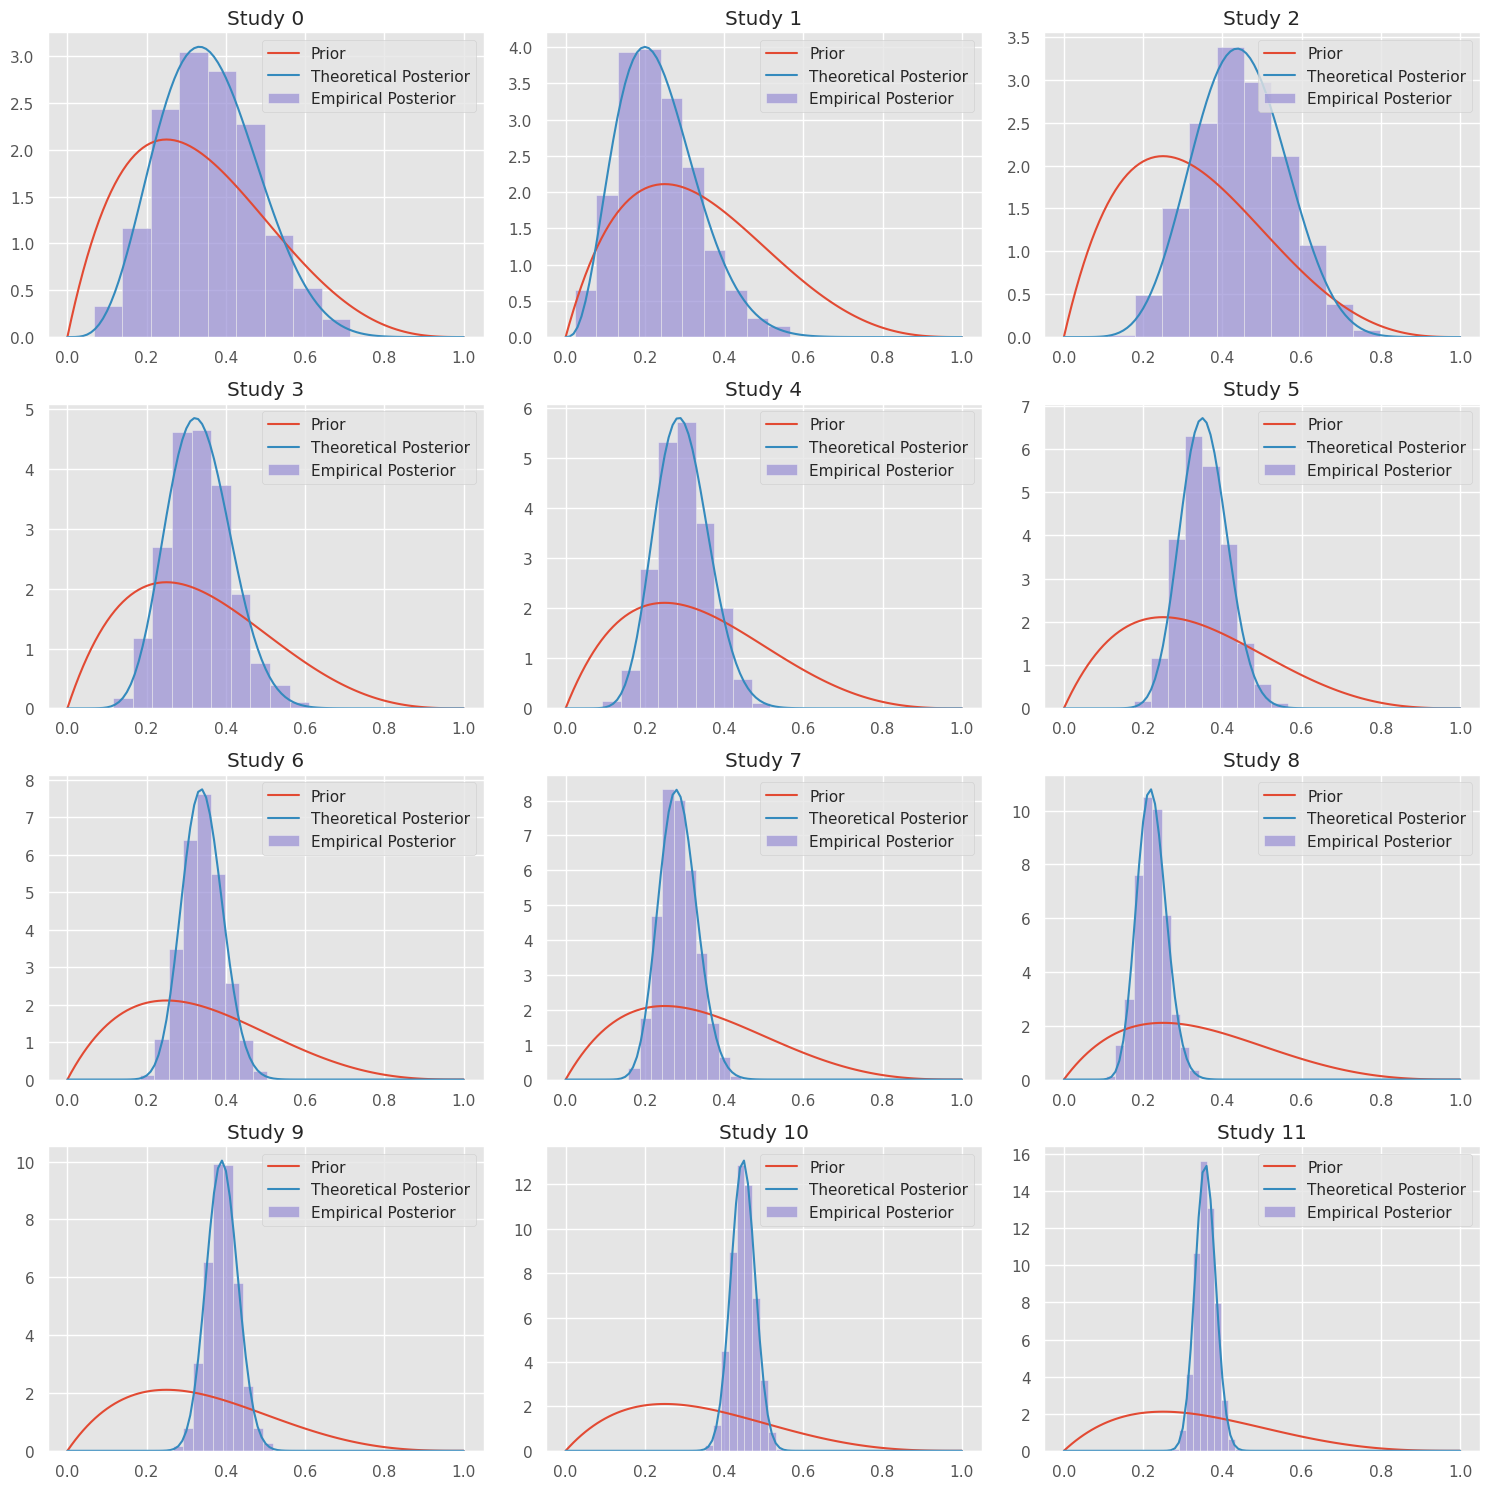

In [31]:
# Plot the resulting densities for a weak prior
fig1 = plot_densities(2, 4, study_df = study_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 6 seconds.


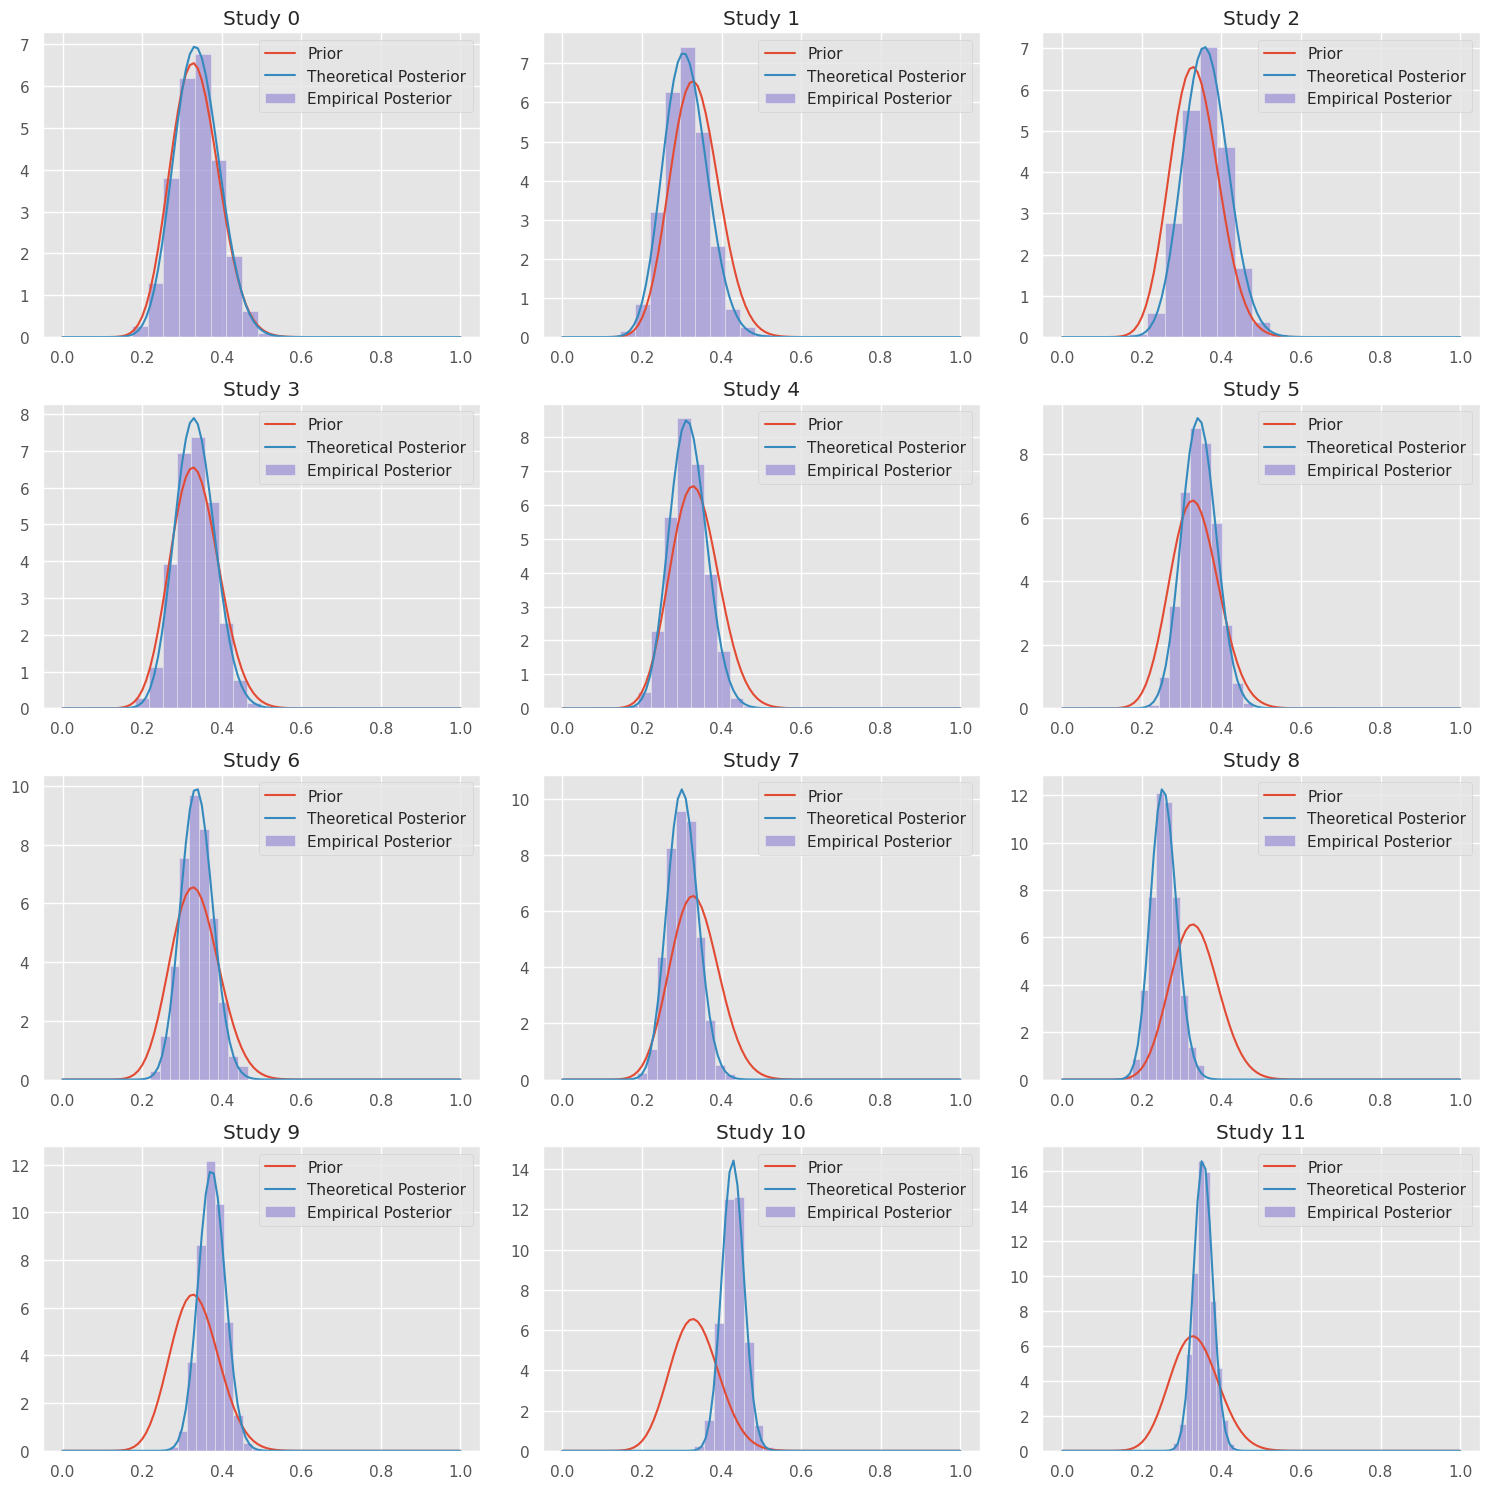

In [32]:
# Plot the resulting densities for a strong prior
fig2 = plot_densities(20, 40, study_df = study_df)

<!-- BEGIN QUESTION -->

### 2d (i) 

Compare the curve of the theoretical distribution with the histogram of samples from the empirical posterior. Are they similar or different?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2d (ii)

Compare the two figures corresponding to 'weak' prior $\theta_i \sim Beta(2,4)$ and 'strong' prior  $\theta_i \sim Beta(20,40)$. How are they different? Explain why.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## 2e) Approximate Inference for a More Complex Model

The previous 2 parts served as a sanity check that the approximate inference techniques used by PyMC can approximate the theoretical posterior. The usefulness of such packages becomes apparent when we are dealing with more complex models that don't have conjugacy properties.

Consider the following graphical model:

![](model_asymptomatic.png)

Recent studies have shown that a large fraction of COVID cases do not show symptoms, but all of the studies considered here tested only symptomatic cases. This means that the probability of testing positive (which what we observe) isn't the same as the SAR $\theta_i$! 

The estimates of the asymptomatic rate fall in the range $[0.18, 0.43]$. We assume a prior $A\sim Uniform(0.18, 0.43)$. This means that the probability that a person in a study tests positive is really $\theta_i*(1-A)$. Hence:

$$X_i|\theta_i, A \sim Binomial(N_i, \theta_i\cdot (1 - A))$$

#### Complete the `approximate_inference_asympotmatic_MCMC` function to add dependence on the asymptomatic rate:

In [36]:
# TODO: complete the function
def approximate_inference_asympotmatic_MCMC(alpha_value, beta_value, study_df = study_df):
    """
    Creates and fits a PyMC model corresponding to the graphical model above
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
    
    Outputs: (model, trace)
    """
    with pm.Model() as model:

        theta = pm.Beta('theta', alpha=alpha_value, beta=beta_value, shape=len(study_df)) # SOLUTION
        A = pm.Uniform('A', lower = 0.18, upper = 0.43) # SOLUTION
        X = pm.Binomial('X', p=theta*(1-A), observed=study_df['X'], n=study_df['N'])
        
        trace = pm.sample(500, tune=1000, target_accept=0.95, return_inferencedata=False, progressbar=False)
    return (model, trace)

In [37]:
grader.check("q2e_i")

q2e_i results:
    q2e_i - 1 result:
        ❌ Test case failed
        Trying:
            nreps = 2
        Expecting nothing
        ok
        Trying:
            logger.setLevel(logging.ERROR)
        Expecting nothing
        ok
        Trying:
            answers = [0.38, 0.3, 0.44, 0.38, 0.36, 0.42, 0.42, 0.36, 0.28, 0.48, 0.56, 0.44]
        Expecting nothing
        ok
        Trying:
            checks = []
        Expecting nothing
        ok
        Trying:
            for _ in range(nreps):
                model_test, trace_test = approximate_inference_asympotmatic_MCMC(5, 10)
                post_samples_test = trace_test['theta']
                estimates = np.mean(post_samples_test, axis = 0)
                rounded_estimates = np.round(estimates / 2, 2) * 2
                checks.append(np.all([rounded_estimates[i] == answers[i] for i in range(len(rounded_estimates))]))
        Expecting nothing
        ok
        Trying:
            logger.setLevel(logging.INFO)
        Expecting nothing
        ok
        Trying:
            assert np.any(checks)
        Expecting nothing
        **********************************************************************
        Line 12, in q2e_i 0
        Failed example:
            assert np.any(checks)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/envs/notebook/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q2e_i 0[6]>", line 1, in <module>
                assert np.any(checks)
            AssertionError

<!-- BEGIN QUESTION -->

Notice that the `trace` now contains samples for both `theta` and `A`!

Plot a histogram of the posterior estimates for $A$ if $\alpha=5$ and $\beta=10$.

In [ ]:
model, trace = approximate_inference_asympotmatic_MCMC(5, 10)
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Assuming the model we defined is correct, what can you conclude about the asymptomatic rate $A$ based on the studies and the model?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## Well done!
You've reached the end of the lab! Make sure you double check your work and make sure that you've answered all the written portions of the lab.

Before you submit to Gradescope, make sure you pass all the autograded portions of this lab. **Run the cell below to generate a PDF of your lab submission**, and **run the last cell to generate a zip file of your lab submission.** Do **not** create your lab PDF by exporting your notebook to a PDF.

To submit your lab to Gradescope, submit the PDF to Lab 4 Written and the zip file to Lab 4 Code.

In [ ]:
import matplotlib.image as mpimg
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("lab04.ipynb", filtering=True, pagebreaks=True)
if(path.exists('lab04.pdf')):
    img = mpimg.imread('baby_rock_hyrax.jpg')
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    display(HTML("Download your PDF <a href='lab04.pdf' download>here</a>."))
    plt.show()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)